In [1]:
import pandas as pd
import numpy as np
import random
import os

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

import tensorflow as tf
tf.random.set_seed(RANDOM_SEED)

X_scaled = pd.read_csv('../data/processed/X_scaled.csv')
y = pd.read_csv('../data/processed/y.csv')['outcome']

mask = ~y.isna()
X_clean = X_scaled[mask]
y_clean = y[mask]

print(f"Loaded data shape: {X_clean.shape}")
print(f"Target shape: {y_clean.shape}")
print(f"\nClass distribution:\n{y_clean.value_counts()}")
print(f"Class imbalance ratio: {y_clean.value_counts()[0] / y_clean.value_counts()[1]:.2f}:1")

Loaded data shape: (1176, 48)
Target shape: (1176,)

Class distribution:
outcome
0.0    1017
1.0     159
Name: count, dtype: int64
Class imbalance ratio: 6.40:1


In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

print("BEFORE SMOTE:")
print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTrain class distribution:\n{pd.Series(y_train).value_counts()}")
print(f"Train class ratio: {y_train.value_counts()[0] / y_train.value_counts()[1]:.2f}:1")

BEFORE SMOTE:
Train set: (940, 48)
Test set: (236, 48)

Train class distribution:
outcome
0.0    813
1.0    127
Name: count, dtype: int64
Train class ratio: 6.40:1


## Applying SMOTE, Training, Evaluating

In [3]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nAFTER SMOTE:")
print(f"Train set shape: {X_train.shape} -> {X_train_smote.shape}")
print(f"Added synthetic samples: {X_train_smote.shape[0] - X_train.shape[0]}")
print(f"\nTrain class distribution:\n{pd.Series(y_train_smote).value_counts()}")
print(f"Train class ratio: {y_train_smote.value_counts()[0] / y_train_smote.value_counts()[1]:.2f}:1")


AFTER SMOTE:
Train set shape: (940, 48) -> (1626, 48)
Added synthetic samples: 686

Train class distribution:
outcome
0.0    813
1.0    813
Name: count, dtype: int64
Train class ratio: 1.00:1


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Training models with SMOTE-balanced data...\n")

print("1. Logistic Regression...")
lr_smote = LogisticRegression(max_iter=1000, random_state=42)
lr_smote.fit(X_train_smote, y_train_smote)
y_pred_lr = lr_smote.predict(X_test)

print("2. Random Forest...")
rf_smote = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1,
)
rf_smote.fit(X_train_smote, y_train_smote)
y_pred_rf = rf_smote.predict(X_test)

print("3. XGBoost...")

xgb_smote = xgb.XGBClassifier(
    n_estimators=300,
    random_state=42,
    eval_metric='logloss',
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9
)
xgb_smote.fit(X_train_smote, y_train_smote)
y_pred_xgb = xgb_smote.predict(X_test)


print("\nAll models trained!")

Training models with SMOTE-balanced data...

1. Logistic Regression...
2. Random Forest...
3. XGBoost...

All models trained!

All models trained!


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

print("4. Neural Network...")

nn_smote = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_smote.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

nn_smote.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_smote.fit(
    X_train_smote, y_train_smote, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.2, 
    verbose=0
)

y_pred_nn = (nn_smote.predict(X_test, verbose=0) > 0.5).astype(int).flatten()

print("Trained Neural Network.")

4. Neural Network...


/Users/sammedsagare/Documents/Coding/ICU-Mortality-Prediction/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Trained Neural Network.


In [6]:
y_test_array = np.array(y_test)

models_binary = {
    'Logistic Regression': y_pred_lr,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'Neural Network': y_pred_nn
}

print("-"*70)
print("BINARY CLASSIFICATION PERFORMANCE (AFTER SMOTE)")
print("-"*70)

for model_name, y_pred in models_binary.items():
    print(f"\n{model_name}:")
    print("-" * 70)
    print(classification_report(y_test_array, y_pred, 
                                target_names=['Survived (0)', 'Died (1)']))
    
    # Show confusion matrix
    cm = confusion_matrix(y_test_array, y_pred)
    print(f"Confusion Matrix:")
    print(f"                Predicted: Survived  Predicted: Died")
    print(f"Actual: Survived       {cm[0][0]:6d}            {cm[0][1]:6d}")
    print(f"Actual: Died           {cm[1][0]:6d}            {cm[1][1]:6d}")
    print("-" * 70)

----------------------------------------------------------------------
BINARY CLASSIFICATION PERFORMANCE (AFTER SMOTE)
----------------------------------------------------------------------

Logistic Regression:
----------------------------------------------------------------------
              precision    recall  f1-score   support

Survived (0)       0.93      0.84      0.88       204
    Died (1)       0.37      0.59      0.45        32

    accuracy                           0.81       236
   macro avg       0.65      0.72      0.67       236
weighted avg       0.85      0.81      0.82       236

Confusion Matrix:
                Predicted: Survived  Predicted: Died
Actual: Survived          171                33
Actual: Died               13                19
----------------------------------------------------------------------

Random Forest:
----------------------------------------------------------------------
              precision    recall  f1-score   support

Survived (

In [7]:
# Binary accuracy comparison
binary_results = {
    'Logistic Regression': accuracy_score(y_test_array, y_pred_lr),
    'Random Forest': accuracy_score(y_test_array, y_pred_rf),
    'XGBoost': accuracy_score(y_test_array, y_pred_xgb),
    'Neural Network': accuracy_score(y_test_array, y_pred_nn)
}

print("\n" + "-"*70)
print("BINARY CLASSIFICATION - MODEL COMPARISON (AFTER SMOTE)")
print("-"*70)
for model, acc in sorted(binary_results.items(), key=lambda x: x[1], reverse=True):
    print(f"{model:20s}: {acc:.4f}")
print("-"*70)


----------------------------------------------------------------------
BINARY CLASSIFICATION - MODEL COMPARISON (AFTER SMOTE)
----------------------------------------------------------------------
XGBoost             : 0.8602
Random Forest       : 0.8559
Neural Network      : 0.8517
Logistic Regression : 0.8051
----------------------------------------------------------------------


In [8]:
from sklearn.metrics import recall_score

print("\n" + "-"*70)
print("RECALL ANALYSIS (Most Important for Imbalanced Data)")
print("-"*70)

for model_name, y_pred in models_binary.items():
    recall_survived = recall_score(y_test_array, y_pred, pos_label=0)
    recall_died = recall_score(y_test_array, y_pred, pos_label=1)
    
    print(f"{model_name:20s}:")
    print(f"  Recall (Survived): {recall_survived:.4f}")
    print(f"  Recall (Died):     {recall_died:.4f}")
    
print("-"*70)
print("Goal: Recall (Died) should be > 0.70 for clinical use")
print("-"*70)


----------------------------------------------------------------------
RECALL ANALYSIS (Most Important for Imbalanced Data)
----------------------------------------------------------------------
Logistic Regression :
  Recall (Survived): 0.8382
  Recall (Died):     0.5938
Random Forest       :
  Recall (Survived): 0.9510
  Recall (Died):     0.2500
XGBoost             :
  Recall (Survived): 0.9559
  Recall (Died):     0.2500
Neural Network      :
  Recall (Survived): 0.9412
  Recall (Died):     0.2812
----------------------------------------------------------------------
Goal: Recall (Died) should be > 0.70 for clinical use
----------------------------------------------------------------------


## Risk Stratification (3-Class), Eval, Compare

In [9]:
def predict_risk_category(probabilities, low_threshold=0.3, high_threshold=0.7):
    """
    Convert predicted probabilities to risk categories.
    
    Args:
        probabilities: Array of predicted probabilities for positive class
        low_threshold: Threshold below which risk is 'Low' (default: 0.3)
        high_threshold: Threshold above which risk is 'High' (default: 0.7)
    
    Returns:
        Array of risk categories: 0 (Low), 1 (Medium), 2 (High)
    """
    risk_categories = np.zeros(len(probabilities), dtype=int)
    risk_categories[(probabilities >= low_threshold) & (probabilities < high_threshold)] = 1
    risk_categories[probabilities >= high_threshold] = 2
    
    return risk_categories

# get predicted probabilities from each model
print("Extracting predicted probabilities...\n")

prob_lr = lr_smote.predict_proba(X_test)[:, 1]
risk_lr = predict_risk_category(prob_lr)

prob_rf = rf_smote.predict_proba(X_test)[:, 1]
risk_rf = predict_risk_category(prob_rf)

prob_xgb = xgb_smote.predict_proba(X_test)[:, 1]
risk_xgb = predict_risk_category(prob_xgb)

prob_nn = nn_smote.predict(X_test, verbose=0).flatten()
risk_nn = predict_risk_category(prob_nn)

print("Risk stratification complete!")

Extracting predicted probabilities...

Risk stratification complete!


In [10]:
# displaying risk distribution for each model
risk_labels = ['Low Risk', 'Medium Risk', 'High Risk']

models_risk = {
    'Logistic Regression': risk_lr,
    'Random Forest': risk_rf,
    'XGBoost': risk_xgb,
    'Neural Network': risk_nn
}

print("\n" + "-"*60)
print("RISK CATEGORY DISTRIBUTION (AFTER SMOTE)")
print("-"*60)

for model_name, risk_pred in models_risk.items():
    print(f"\n{model_name}:")
    print("-" * 40)
    unique, counts = np.unique(risk_pred, return_counts=True)
    for risk_level, count in zip(unique, counts):
        percentage = (count / len(risk_pred)) * 100
        print(f"  {risk_labels[risk_level]:15s}: {count:4d} ({percentage:5.1f}%)")

print("-"*60)


------------------------------------------------------------
RISK CATEGORY DISTRIBUTION (AFTER SMOTE)
------------------------------------------------------------

Logistic Regression:
----------------------------------------
  Low Risk       :  160 ( 67.8%)
  Medium Risk    :   43 ( 18.2%)
  High Risk      :   33 ( 14.0%)

Random Forest:
----------------------------------------
  Low Risk       :  167 ( 70.8%)
  Medium Risk    :   64 ( 27.1%)
  High Risk      :    5 (  2.1%)

XGBoost:
----------------------------------------
  Low Risk       :  212 ( 89.8%)
  Medium Risk    :    9 (  3.8%)
  High Risk      :   15 (  6.4%)

Neural Network:
----------------------------------------
  Low Risk       :  210 ( 89.0%)
  Medium Risk    :    9 (  3.8%)
  High Risk      :   17 (  7.2%)
------------------------------------------------------------


In [11]:
# evaluating risk stratification performance
print("\n" + "-"*70)
print("RISK STRATIFICATION PERFORMANCE (AFTER SMOTE)")
print("-"*70)

for model_name, risk_pred in models_risk.items():
    print(f"\n{model_name}:")
    print("-" * 70)
    
    risk_binary = risk_pred.copy()
    risk_binary[risk_binary == 1] = 0  # Medium -> Low for comparison
    risk_binary[risk_binary == 2] = 1  # High -> High
    
    print(classification_report(y_test_array, risk_binary, 
                                target_names=['Low/Medium Risk', 'High Risk']))
    
    cm = confusion_matrix(y_test_array, risk_binary)
    print(f"Confusion Matrix:")
    print(f"                Predicted: Low/Med  Predicted: High")
    print(f"Actual: Survived       {cm[0][0]:6d}            {cm[0][1]:6d}")
    print(f"Actual: Died           {cm[1][0]:6d}            {cm[1][1]:6d}")
    print("-" * 70)


----------------------------------------------------------------------
RISK STRATIFICATION PERFORMANCE (AFTER SMOTE)
----------------------------------------------------------------------

Logistic Regression:
----------------------------------------------------------------------
                 precision    recall  f1-score   support

Low/Medium Risk       0.91      0.91      0.91       204
      High Risk       0.42      0.44      0.43        32

       accuracy                           0.84       236
      macro avg       0.67      0.67      0.67       236
   weighted avg       0.85      0.84      0.84       236

Confusion Matrix:
                Predicted: Low/Med  Predicted: High
Actual: Survived          185                19
Actual: Died               18                14
----------------------------------------------------------------------

Random Forest:
----------------------------------------------------------------------
                 precision    recall  f1-score   

In [12]:
# Risk stratification accuracy comparison
risk_results = {}

for model_name, risk_pred in models_risk.items():
    # Convert to binary for fair comparison
    risk_binary = risk_pred.copy()
    risk_binary[risk_binary == 1] = 0  # Medium -> Low
    risk_binary[risk_binary == 2] = 1  # High
    
    acc = accuracy_score(y_test_array, risk_binary)
    risk_results[model_name] = acc

print("\n" + "-"*70)
print("RISK STRATIFICATION - MODEL COMPARISON (AFTER SMOTE)")
print("-"*70)
for model, acc in sorted(risk_results.items(), key=lambda x: x[1], reverse=True):
    print(f"{model:20s}: {acc:.4f}")
print("-"*70)

# Compare Binary vs Risk accuracy
print("\nBinary vs Risk Accuracy Comparison:")
print("-" * 70)
for model in binary_results.keys():
    print(f"{model:20s} - Binary: {binary_results[model]:.4f} | Risk: {risk_results[model]:.4f}")
print("-" * 70)


----------------------------------------------------------------------
RISK STRATIFICATION - MODEL COMPARISON (AFTER SMOTE)
----------------------------------------------------------------------
Random Forest       : 0.8686
Neural Network      : 0.8686
XGBoost             : 0.8602
Logistic Regression : 0.8432
----------------------------------------------------------------------

Binary vs Risk Accuracy Comparison:
----------------------------------------------------------------------
Logistic Regression  - Binary: 0.8051 | Risk: 0.8432
Random Forest        - Binary: 0.8559 | Risk: 0.8686
XGBoost              - Binary: 0.8602 | Risk: 0.8602
Neural Network       - Binary: 0.8517 | Risk: 0.8686
----------------------------------------------------------------------


In [13]:
# Risk performance validation (death rate by risk category)
print("\n" + "-"*70)
print("RISK CATEGORY VALIDATION - ACTUAL DEATH RATES (XGBoost)")
print("-"*70)

risk_performance = pd.DataFrame({
    'Risk Category': risk_labels,
    'Count': [np.sum(risk_xgb == i) for i in range(3)],
    'Actual Deaths': [np.sum(y_test_array[risk_xgb == i]) for i in range(3)],
    'Death Rate (%)': [np.mean(y_test_array[risk_xgb == i]) * 100 if np.sum(risk_xgb == i) > 0 else 0 for i in range(3)]
})

print(risk_performance.to_string(index=False))
print("-"*70)

print("\nInterpretation:")
print("- Low Risk: Should have low death rate")
print("- Medium Risk: Intermediate death rate")
print("- High Risk: Should have high death rate")


----------------------------------------------------------------------
RISK CATEGORY VALIDATION - ACTUAL DEATH RATES (XGBoost)
----------------------------------------------------------------------
Risk Category  Count  Actual Deaths  Death Rate (%)
     Low Risk    212           21.0        9.905660
  Medium Risk      9            4.0       44.444444
    High Risk     15            7.0       46.666667
----------------------------------------------------------------------

Interpretation:
- Low Risk: Should have low death rate
- Medium Risk: Intermediate death rate
- High Risk: Should have high death rate


## visualization

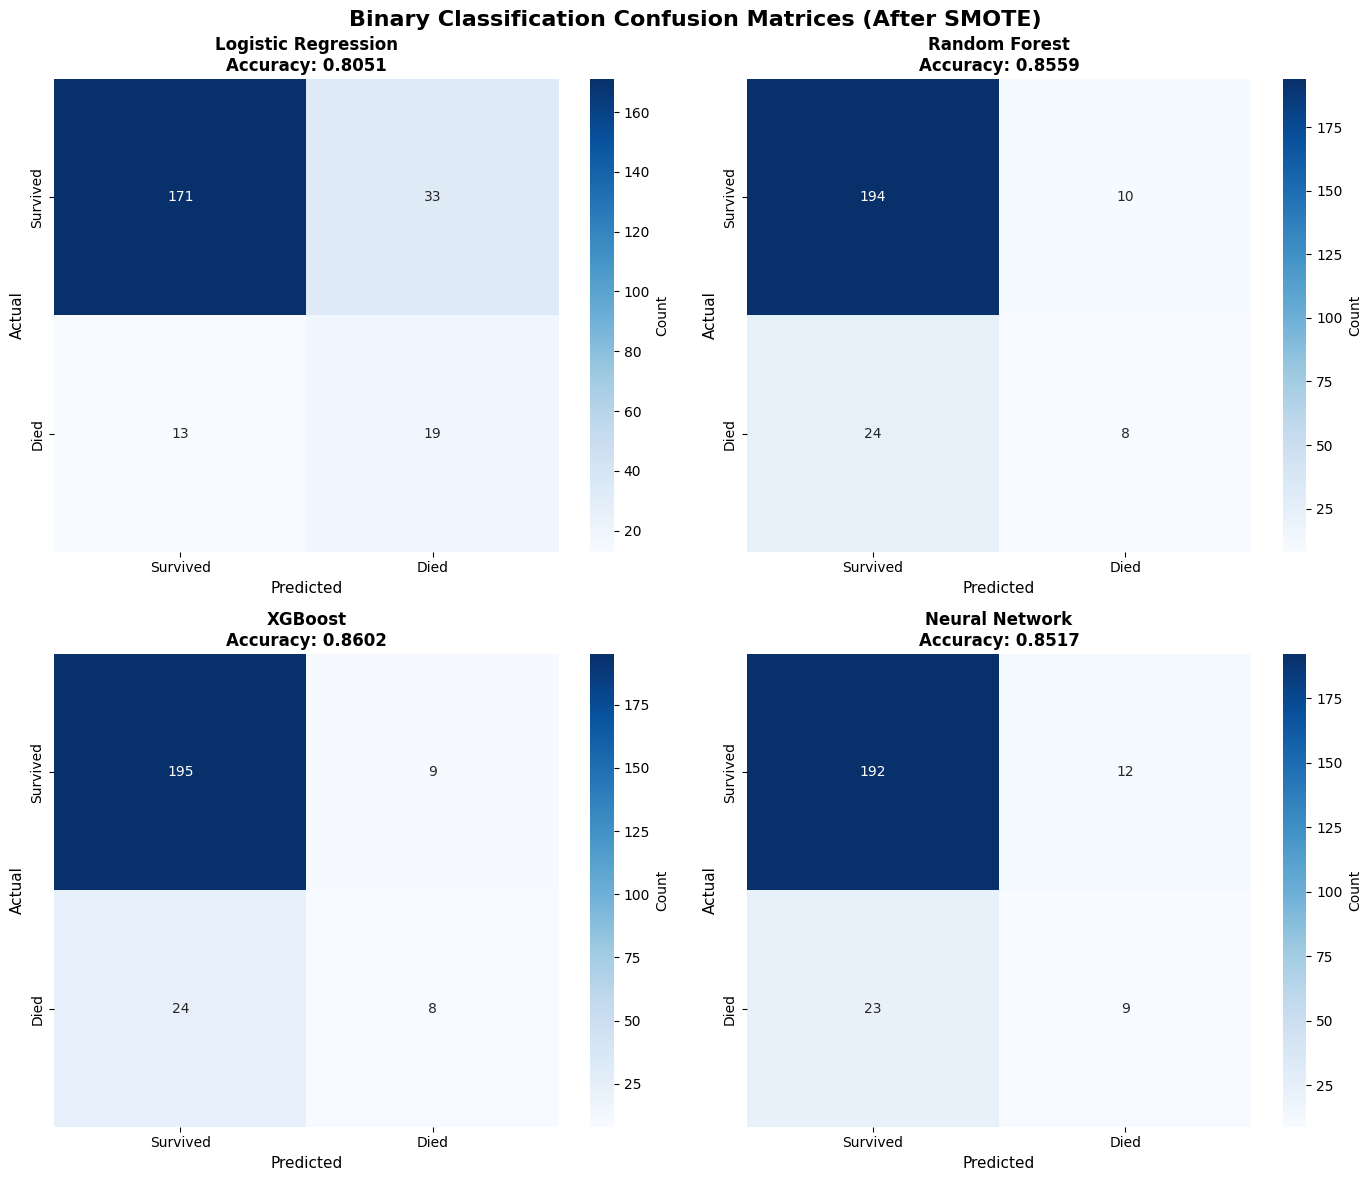

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrices for all models (binary classification)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Binary Classification Confusion Matrices (After SMOTE)', 
             fontsize=16, fontweight='bold')

models_list = [
    ('Logistic Regression', y_pred_lr),
    ('Random Forest', y_pred_rf),
    ('XGBoost', y_pred_xgb),
    ('Neural Network', y_pred_nn)
]

for idx, (name, y_pred) in enumerate(models_list):
    ax = axes[idx // 2, idx % 2]
    cm = confusion_matrix(y_test_array, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Survived', 'Died'],
                yticklabels=['Survived', 'Died'],
                cbar_kws={'label': 'Count'})
    
    ax.set_title(f'{name}\nAccuracy: {accuracy_score(y_test_array, y_pred):.4f}', 
                fontsize=12, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=11)
    ax.set_xlabel('Predicted', fontsize=11)

plt.tight_layout()
plt.show()

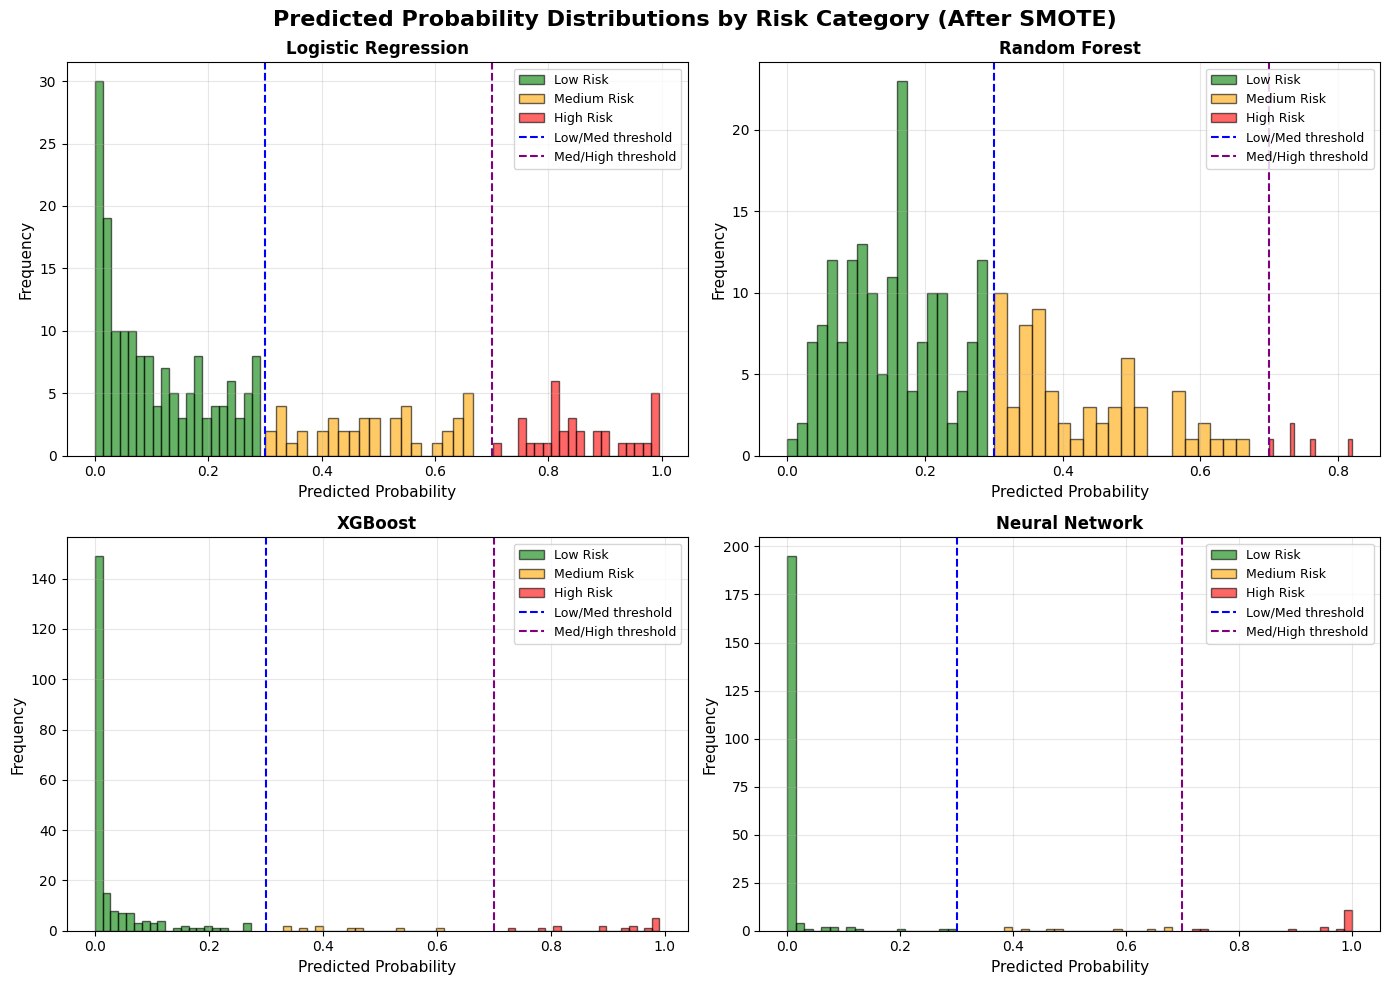

In [15]:
# Probability distributions by risk category
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Predicted Probability Distributions by Risk Category (After SMOTE)', 
             fontsize=16, fontweight='bold')

models_prob = [
    ('Logistic Regression', prob_lr, risk_lr),
    ('Random Forest', prob_rf, risk_rf),
    ('XGBoost', prob_xgb, risk_xgb),
    ('Neural Network', prob_nn, risk_nn)
]

colors = ['green', 'orange', 'red']

for idx, (name, probs, risks) in enumerate(models_prob):
    ax = axes[idx // 2, idx % 2]
    
    # Plot histogram for each risk category
    for risk_level in range(3):
        mask = risks == risk_level
        if np.sum(mask) > 0:
            ax.hist(probs[mask], bins=20, alpha=0.6, label=risk_labels[risk_level], 
                   color=colors[risk_level], edgecolor='black')
    
    ax.axvline(x=0.3, color='blue', linestyle='--', linewidth=1.5, label='Low/Med threshold')
    ax.axvline(x=0.7, color='purple', linestyle='--', linewidth=1.5, label='Med/High threshold')
    
    ax.set_xlabel('Predicted Probability', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Stratified K-Fold Cross-Validation

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, f1_score, roc_auc_score, average_precision_score
from imblearn.over_sampling import SMOTE

# Use 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("-"*70)
print("STRATIFIED K-FOLD CROSS-VALIDATION (5 Folds)")
print("-"*70)

# Store results for each model
cv_results = {
    'Logistic Regression': {'recall': [], 'f1': [], 'auc': [], 'ap': []},
    'Random Forest': {'recall': [], 'f1': [], 'auc': [], 'ap': []},
    'XGBoost': {'recall': [], 'f1': [], 'auc': [], 'ap': []}
}

for fold_num, (train_idx, val_idx) in enumerate(skf.split(X_clean, y_clean), start=1):
    print(f"\nFold {fold_num}/5:")
    print("-" * 70)
    
    # Split data for this fold
    X_fold_train, X_fold_val = X_clean.iloc[train_idx], X_clean.iloc[val_idx]
    y_fold_train, y_fold_val = y_clean.iloc[train_idx], y_clean.iloc[val_idx]
    
    # Apply SMOTE to training fold only (safer k_neighbors when minority is small)
    minority_count = int((y_fold_train == 1).sum())
    k_use = max(1, min(5, minority_count - 1))
    smote_fold = SMOTE(random_state=42, k_neighbors=k_use, sampling_strategy=1.0)
    X_fold_smote, y_fold_smote = smote_fold.fit_resample(X_fold_train, y_fold_train)
    
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_fold_smote, y_fold_smote)
    y_prob_lr_fold = lr.predict_proba(X_fold_val)[:, 1]
    y_pred_lr_fold = (y_prob_lr_fold >= 0.5).astype(int)
    
    cv_results['Logistic Regression']['recall'].append(recall_score(y_fold_val, y_pred_lr_fold, pos_label=1))
    cv_results['Logistic Regression']['f1'].append(f1_score(y_fold_val, y_pred_lr_fold, pos_label=1))
    cv_results['Logistic Regression']['auc'].append(roc_auc_score(y_fold_val, y_prob_lr_fold))
    cv_results['Logistic Regression']['ap'].append(average_precision_score(y_fold_val, y_prob_lr_fold))

    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(X_fold_smote, y_fold_smote)
    y_prob_rf_fold = rf.predict_proba(X_fold_val)[:, 1]
    y_pred_rf_fold = (y_prob_rf_fold >= 0.5).astype(int)
    
    cv_results['Random Forest']['recall'].append(recall_score(y_fold_val, y_pred_rf_fold, pos_label=1))
    cv_results['Random Forest']['f1'].append(f1_score(y_fold_val, y_pred_rf_fold, pos_label=1))
    cv_results['Random Forest']['auc'].append(roc_auc_score(y_fold_val, y_prob_rf_fold))
    cv_results['Random Forest']['ap'].append(average_precision_score(y_fold_val, y_prob_rf_fold))
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=300,
        random_state=42,
        eval_metric='logloss',
        max_depth=6,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9
    )
    xgb_model.fit(X_fold_smote, y_fold_smote)
    y_prob_xgb_fold = xgb_model.predict_proba(X_fold_val)[:, 1]
    y_pred_xgb_fold = (y_prob_xgb_fold >= 0.5).astype(int)
    
    cv_results['XGBoost']['recall'].append(recall_score(y_fold_val, y_pred_xgb_fold, pos_label=1))
    cv_results['XGBoost']['f1'].append(f1_score(y_fold_val, y_pred_xgb_fold, pos_label=1))
    cv_results['XGBoost']['auc'].append(roc_auc_score(y_fold_val, y_prob_xgb_fold))
    cv_results['XGBoost']['ap'].append(average_precision_score(y_fold_val, y_prob_xgb_fold))
    
    print(f"  LR  - Recall: {cv_results['Logistic Regression']['recall'][-1]:.4f}")
    print(f"  RF  - Recall: {cv_results['Random Forest']['recall'][-1]:.4f}")
    print(f"  XGB - Recall: {cv_results['XGBoost']['recall'][-1]:.4f}")

print("\n" + "-"*70)
print("✓ Cross-validation complete!")
print("-"*70)

----------------------------------------------------------------------
STRATIFIED K-FOLD CROSS-VALIDATION (5 Folds)
----------------------------------------------------------------------

Fold 1/5:
----------------------------------------------------------------------
  LR  - Recall: 0.5625
  RF  - Recall: 0.2500
  XGB - Recall: 0.2812

Fold 2/5:
----------------------------------------------------------------------
  LR  - Recall: 0.5625
  RF  - Recall: 0.2500
  XGB - Recall: 0.2812

Fold 2/5:
----------------------------------------------------------------------
  LR  - Recall: 0.6129
  RF  - Recall: 0.2903
  XGB - Recall: 0.2903

Fold 3/5:
----------------------------------------------------------------------
  LR  - Recall: 0.6129
  RF  - Recall: 0.2903
  XGB - Recall: 0.2903

Fold 3/5:
----------------------------------------------------------------------
  LR  - Recall: 0.6562
  RF  - Recall: 0.3125
  XGB - Recall: 0.3125

Fold 4/5:
-----------------------------------------------

In [17]:
# Display cross-validation results summary
print("\n" + "-"*70)
print("CROSS-VALIDATION RESULTS (Mean ± Std)")
print("-"*70)

cv_summary = []

for model_name in cv_results.keys():
    recall_mean = np.mean(cv_results[model_name]['recall'])
    recall_std = np.std(cv_results[model_name]['recall'])
    f1_mean = np.mean(cv_results[model_name]['f1'])
    f1_std = np.std(cv_results[model_name]['f1'])
    auc_mean = np.mean(cv_results[model_name]['auc'])
    auc_std = np.std(cv_results[model_name]['auc'])
    ap_mean = np.mean(cv_results[model_name]['ap'])
    ap_std = np.std(cv_results[model_name]['ap'])
    
    cv_summary.append({
        'Model': model_name,
        'Recall (Died)': f"{recall_mean:.4f} ± {recall_std:.4f}",
        'F1-Score': f"{f1_mean:.4f} ± {f1_std:.4f}",
        'ROC-AUC': f"{auc_mean:.4f} ± {auc_std:.4f}",
        'PR-AUC': f"{ap_mean:.4f} ± {ap_std:.4f}"
    })
    
    print(f"\n{model_name}:")
    print(f"  Recall (Died): {recall_mean:.4f} ± {recall_std:.4f}")
    print(f"  F1-Score:      {f1_mean:.4f} ± {f1_std:.4f}")
    print(f"  ROC-AUC:       {auc_mean:.4f} ± {auc_std:.4f}")
    print(f"  PR-AUC:        {ap_mean:.4f} ± {ap_std:.4f}")

print("\n" + "-"*70)

# Create DataFrame for better visualization
cv_summary_df = pd.DataFrame(cv_summary)
print("\nSummary Table:")
print(cv_summary_df.to_string(index=False))
print("-"*70)

print("\nCross-validation provides more robust performance estimates!")
print("Lower std = more stable model across different data splits")


----------------------------------------------------------------------
CROSS-VALIDATION RESULTS (Mean ± Std)
----------------------------------------------------------------------

Logistic Regression:
  Recall (Died): 0.6163 ± 0.0305
  F1-Score:      0.4181 ± 0.0383
  ROC-AUC:       0.7653 ± 0.0313
  PR-AUC:        0.4749 ± 0.0334

Random Forest:
  Recall (Died): 0.3143 ± 0.0513
  F1-Score:      0.3978 ± 0.0378
  ROC-AUC:       0.8034 ± 0.0134
  PR-AUC:        0.4568 ± 0.0425

XGBoost:
  Recall (Died): 0.3081 ± 0.0530
  F1-Score:      0.3704 ± 0.0309
  ROC-AUC:       0.7966 ± 0.0226
  PR-AUC:        0.4584 ± 0.0398

----------------------------------------------------------------------

Summary Table:
              Model   Recall (Died)        F1-Score         ROC-AUC          PR-AUC
Logistic Regression 0.6163 ± 0.0305 0.4181 ± 0.0383 0.7653 ± 0.0313 0.4749 ± 0.0334
      Random Forest 0.3143 ± 0.0513 0.3978 ± 0.0378 0.8034 ± 0.0134 0.4568 ± 0.0425
            XGBoost 0.3081 ± 0.0530

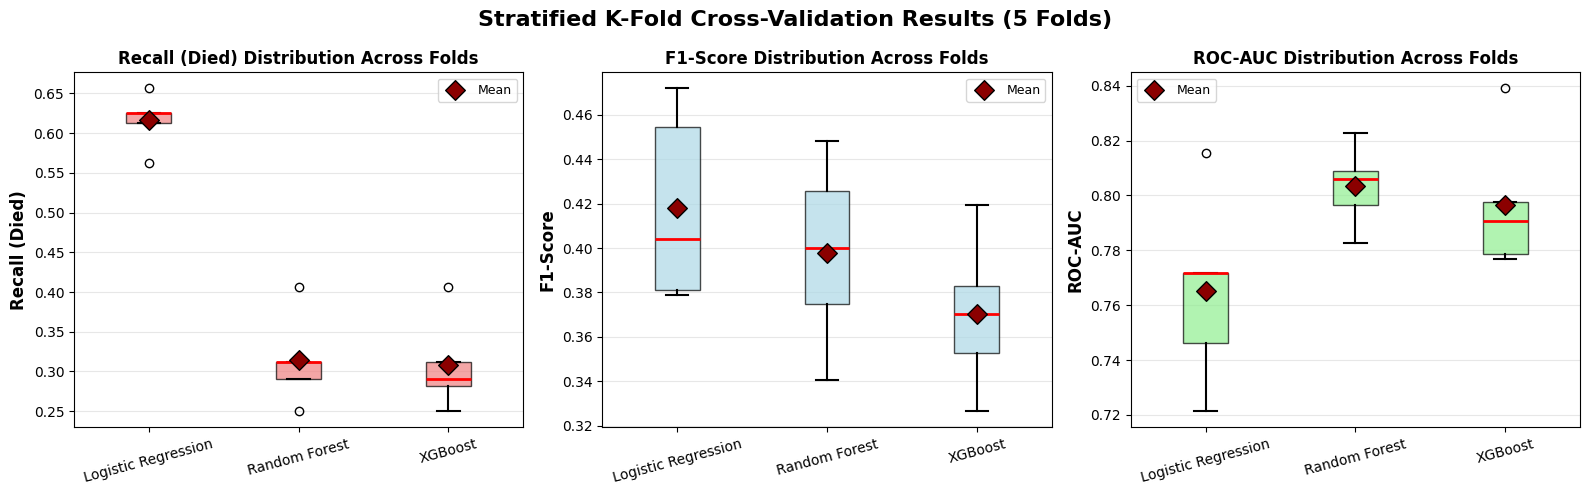


Interpretation:
- Box shows middle 50% of results (interquartile range)
- Red line = median, Red diamond = mean
- Smaller box = more consistent performance across folds
- Whiskers show min/max values


In [18]:
# Visualize cross-validation results with boxplots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Stratified K-Fold Cross-Validation Results (5 Folds)', 
             fontsize=16, fontweight='bold')

metrics = ['recall', 'f1', 'auc']
titles = ['Recall (Died)', 'F1-Score', 'ROC-AUC']
colors = ['lightcoral', 'lightblue', 'lightgreen']

for idx, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    ax = axes[idx]
    
    # Prepare data for boxplot
    data_to_plot = [cv_results[model][metric] for model in cv_results.keys()]
    model_names = list(cv_results.keys())
    
    # Create boxplot
    bp = ax.boxplot(data_to_plot, tick_labels=model_names, patch_artist=True,
                    medianprops=dict(color='red', linewidth=2),
                    boxprops=dict(facecolor=color, alpha=0.7),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))
    
    # Add mean markers
    means = [np.mean(cv_results[model][metric]) for model in model_names]
    ax.scatter(range(1, len(model_names)+1), means, 
              color='darkred', marker='D', s=100, zorder=3, 
              label='Mean', edgecolors='black', linewidths=1)
    
    ax.set_ylabel(title, fontsize=12, fontweight='bold')
    ax.set_title(f'{title} Distribution Across Folds', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=15)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Box shows middle 50% of results (interquartile range)")
print("- Red line = median, Red diamond = mean")
print("- Smaller box = more consistent performance across folds")
print("- Whiskers show min/max values")

In [19]:
print("\n" + "-"*70)
print("SINGLE SPLIT vs CROSS-VALIDATION COMPARISON")
print("-"*70)

comparison_data = []

for model_name in ['Logistic Regression', 'Random Forest', 'XGBoost']:
    # Get single split recall (from earlier evaluation)
    if model_name == 'Logistic Regression':
        single_split_recall = recall_score(y_test_array, y_pred_lr)
    elif model_name == 'Random Forest':
        single_split_recall = recall_score(y_test_array, y_pred_rf)
    else:  # XGBoost
        single_split_recall = recall_score(y_test_array, y_pred_xgb)
    
    # Get CV recall
    cv_recall_mean = np.mean(cv_results[model_name]['recall'])
    cv_recall_std = np.std(cv_results[model_name]['recall'])
    
    comparison_data.append({
        'Model': model_name,
        'Single Split Recall': f"{single_split_recall:.4f}",
        'CV Recall (Mean ± Std)': f"{cv_recall_mean:.4f} ± {cv_recall_std:.4f}",
        'Difference': f"{abs(single_split_recall - cv_recall_mean):.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n" + "-"*70)
print("Insights:")
print("- If Single Split ≈ CV Mean: Single split was representative")
print("- If Single Split >> CV Mean: Single split was 'lucky' (overly optimistic)")
print("- If Single Split << CV Mean: Single split was 'unlucky' (overly pessimistic)")
print("- High CV Std: Model is unstable across different data splits")
print("-"*70)


----------------------------------------------------------------------
SINGLE SPLIT vs CROSS-VALIDATION COMPARISON
----------------------------------------------------------------------
              Model Single Split Recall CV Recall (Mean ± Std) Difference
Logistic Regression              0.5938        0.6163 ± 0.0305     0.0226
      Random Forest              0.2500        0.3143 ± 0.0513     0.0643
            XGBoost              0.2500        0.3081 ± 0.0530     0.0581

----------------------------------------------------------------------
Insights:
- If Single Split ≈ CV Mean: Single split was representative
- If Single Split >> CV Mean: Single split was 'lucky' (overly optimistic)
- If Single Split << CV Mean: Single split was 'unlucky' (overly pessimistic)
- High CV Std: Model is unstable across different data splits
----------------------------------------------------------------------
